In [1]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma, wishart, multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Custom modules we made for specialized analysis and regression
import Regression_function as rf

## Compute utility => our utility function 
## compute_mean_and_variance_recursive=> Mu sum, sigma sum


In [7]:
# import image module 
from IPython.display import Image 
  
# get the image 
Image(url="musumsigmasum.png") 

In [9]:
def compute_utility(cumulative_returns, r_f, T_prime, omega, A):
    """
    Compute the utility of a portfolio given allocation `omega`.

    Parameters in order:
        - Simulated cumulative returns of the risky asset.
        - Risk-free rate.
        - Investment horizon.
        - Proportion allocated to the risky asset.
        - Risk aversion coefficient.

    Returns:
        - Utility value.
    """
    portfolio_returns = ((1 - omega) * np.exp(r_f * T_prime)) + (omega * np.exp(r_f * T_prime + cumulative_returns))
    return np.mean(((portfolio_returns) ** (1 - A)) / (1 - A))

def negative_utility(omega, cumulative_returns, r_f, T_prime, A):
    return -compute_utility(cumulative_returns, r_f, T_prime, omega, A)

def compute_mean_and_variance_recursive(z_t, a, B, Sigma, T_hat):
    """
    Compute the mean (mu_sum) and variance (Sigma_sum) for the updated recursive system.

    Parameters in order:
        - Initial state vector.
        - Mean shift vector of shape (n,).
        - Transition matrix of shape (m, m).
        - Covariance matrix of shape (n, n).
        - # steps (T^).

    Returns a tuple:
        - Updated mean vector of shape (n,).
        - Updated variance-covariance matrix of shape (n, n).
    """
    m = B.shape[0]  # Size of the transition matrix B
    n = m + 2       # Size of augmented system
    B0 = B          # Build B0 block matrix

    # Initialize mean and variance
    mu_sum = np.zeros(2)
    Sigma_sum = Sigma.copy()

    # Recursive calculation of the mean
    for t in range(T_hat):
        mu_sum = np.add(mu_sum,(T_hat - t) * np.linalg.matrix_power(B0, t) @ a)

    # Add the contribution of z_t
    for t in range(T_hat):
        mu_sum += np.linalg.matrix_power(B0, t + 1) @ z_t

    # Recursive calculation of variance
    for t in range(1, T_hat):
        B_sum = sum(np.linalg.matrix_power(B0, j) for j in range(t))
        Sigma_sum += B_sum @ Sigma @ B_sum.T

    if isinstance(mu_sum, np.matrix):
        mu_sum = np.squeeze(np.asarray(mu_sum))

    return mu_sum, Sigma_sum

## parameter uncertainty VAR model => not used, but implemented from the paper

In [10]:
def bayesian_var_sampler_VAR(Z, p, n_samples):
    """
    Bayesian VAR sampling framework based on Zellner's approach for a VAR(p) model.

    Parameters in order:
        - Time series data matrix (T x m) with variables like log returns and dividend yield.
        - Order of the VAR model.
        - # posterior samples to generate.

    Returns a tuple:
        - Samples of coefficient matrices C (including lags).
        - Samples of residual covariance matrices Σ.
    """
    T, m = Z.shape  # T: observations, m: variables (e.g., log returns, dividend yield)

    # Create the lagged matrix X for VAR(p)
    X = []
    for i in range(1, p + 1):
        X.append(Z.iloc[p - i:T - i, :])
    X = np.hstack(X)  # Concatenate lagged matrices horizontally
    X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add a constant (bias) column
    
    # Align Z with X
    Z = Z[p:].reset_index(drop=True)
    
    # Dimensions of the regressor matrix
    n = X.shape[1]  # Number of regressors
    
    # OLS estimator for coefficients
    XTX_inv = np.linalg.inv(X.T @ X)
    C_hat = XTX_inv @ X.T @ Z
    S = (Z - X @ C_hat).T @ (Z - X @ C_hat) 

    # Initialization for posterior sampling
    campioni_C, campioni_Sigma = [], []
    
    for _ in range(n_samples):
        # 1. Sample Σ^-1 from the Wishart distribution
        Sigma_inv = wishart.rvs(df=T - n - 2, scale=np.linalg.inv(S))
        Sigma = np.linalg.inv(Sigma_inv)
        campioni_Sigma.append(Sigma)

        # 2. Sample vec(C) from the conditional multivariate normal distribution
        Sigma_kron = np.kron(Sigma, XTX_inv)
        mean_vec_C = C_hat.to_numpy().flatten()
        vec_C = multivariate_normal.rvs(mean=mean_vec_C, cov=Sigma_kron)
        C = vec_C.reshape((n, m))
        campioni_C.append(C)
    
    return campioni_C, campioni_Sigma

## Create var model (P=1)

In [11]:
def Var_Modelling(Stocks_Model, T=0):
    """
    Fit a VAR(1) model to the stock data after stationarity checks.

    Parameters in order:
        - Dataframe with stock and yield log returns.
        - # observations to trim from the beginning.

    Returns:
        - Fitted VAR model results.
    """
    Stocks_Model = Stocks_Model.iloc[int(T):, :]

    # Perform stationarity tests
    
    adf_log = rf.adf_test(Stocks_Model)
    log_stat, log_non_stat = rf.stationarity_and_not_stationary(adf_log)
    print(log_stat)

    if len(log_non_stat) > 0:
        warnings.warn("Non-stationary data detected. VAR model may be invalid.")
        return []
    
    print(f"Fitting VAR model with T = {len(Stocks_Model)} observations.")
    model = VAR(Stocks_Model)
    return model.fit(1)

## Retrive Data from Excel file and calculate stationary series(first diff)

In [12]:
# Load datasets and preprocess returns
Stocks = pd.read_excel("Data.xlsx", "SPX500").iloc[:, 1]
Yield = pd.read_excel("Data.xlsx", "Yield").iloc[:, 0]
RFREE = pd.read_excel("Data.xlsx", "Rate").iloc[:, 1] / (12 * 100)
GovIndex = pd.read_excel("Data.xlsx", "GOV10Index").iloc[:, 1]

# Calculate returns for stocks, yield, and bonds
returns_stocks = pd.Series(np.subtract(np.array(np.log(Stocks) - np.log(Stocks.shift(1))), RFREE)).dropna()
First_Diff_Yield = pd.Series(np.array(np.log(Yield) - np.log(Yield.shift(1)))).dropna()
returns_bond = pd.Series(np.array(np.log(GovIndex) - np.log(GovIndex.shift(1)))).dropna()
T = len(returns_stocks)


Stocks_2007 = pd.read_excel("Data_2007.xlsx", "SPX500").iloc[:, 1]
Yield_2007 = pd.read_excel("Data_2007.xlsx", "Yield").iloc[:, 0]
RFREE_2007 = pd.read_excel("Data_2007.xlsx", "Rate").iloc[:, 1] / (12 * 100)
GovIndex_2007 = pd.read_excel("Data_2007.xlsx", "GOV10Index").iloc[:, 1]

returns_stocks_2007 = pd.Series(np.subtract(np.array(np.log(Stocks_2007) - np.log(Stocks_2007.shift(1))), RFREE_2007)).dropna()
First_Diff_Yield_2007 = pd.Series(np.array(np.log(Yield_2007) - np.log(Yield_2007.shift(1)))).dropna()
returns_bond_2007 = pd.Series(np.array(np.log(GovIndex_2007) - np.log(GovIndex_2007.shift(1)))).dropna()
T_2007 = len(returns_stocks_2007)


In [ ]:
# Prepare data for VAR modeling
Stocks_Model = pd.concat([returns_stocks, First_Diff_Yield], axis=1)
Stocks_Model.columns = ["Log_returns", "First_diff_Div"]
T_p = ((T - 1) / 2)
Stocks_Model_reduced = Stocks_Model.iloc[int(T_p):, :]

# Fit VAR models
res = Var_Modelling(Stocks_Model)
res2 = Var_Modelling(Stocks_Model_reduced)


# retrive VAR model parameters, a,b,sigma
X = res.params
test = np.matrix(X)

X_1 = res2.params
test_1 = np.matrix(X_1)


['Log_returns', 'First_diff_Div']
Fitting VAR model with T = 442 observations.
['Log_returns', 'First_diff_Div']
Fitting VAR model with T = 222 observations.


## figure = 1 => no predict, uncertainty, no_uncertainty
## figure = 2 => predict with uncertainty and no_uncertainty, no predict uncert,no uncert

In [14]:
def Posterior(returns_stocks, returns_bond, T, figure = 1):
    
    if figure not in [1, 2]:
        raise ValueError("figure must be either 1 or 2.")

    num_simulations = 1000000
    
    # Posterior distribution for mean and variance
    r_bar = np.mean(returns_stocks)
    squared_diff_sum = np.sum((returns_stocks - r_bar) ** 2)
    alpha = (T - 1) / 2
    beta = squared_diff_sum / 2

    sigma2_posterior = invgamma.rvs(a=alpha, scale=beta, size=num_simulations)
    mu_posterior = np.random.normal(loc=r_bar, scale=np.sqrt(sigma2_posterior / T), size=num_simulations)

    r_f = np.mean(returns_bond)

    if figure == 1:
        
        Aversion=[5,10] # Risk aversion coefficient 

        results_incorporated = {A: {"1988-2024": [], "2007-2024": []} for A in Aversion}
        results_fixed = {A: {"1988-2024": [], "2007-2024": []} for A in Aversion}

        for period, start_year in zip(["1988-2024", "2007-2024"], [1988, 2007]):
            for T_prime in [1, 5, 10]:
                predictive_returns = np.random.normal(mu_posterior[:, None], np.sqrt(sigma2_posterior[:, None]), (num_simulations, T_prime * 12))
                cumulative_predictive_returns = np.sum(predictive_returns, axis=1)

                fixed_mu = r_bar
                fixed_sigma = np.sqrt(squared_diff_sum / T)
                fixed_returns = np.random.normal(fixed_mu, fixed_sigma, (num_simulations, T_prime * 12))
                cumulative_fixed_returns = np.sum(fixed_returns, axis=1)

                for A in Aversion:
                    result_predictive = minimize(negative_utility, x0=0.5, args=(cumulative_predictive_returns, r_f, T_prime, A),
                                                 bounds=[(0, 1)], method="L-BFGS-B")
                    results_incorporated[A][period].append(result_predictive.x[0])

                    result_fixed = minimize(negative_utility, x0=0.5, args=(cumulative_fixed_returns, r_f, T_prime, A),
                                            bounds=[(0, 1)], method="L-BFGS-B")
                    results_fixed[A][period].append(result_fixed.x[0])

        
    else:
        
        # Compute cumulative returns with and without uncertainty
        cumulative_returns_with_uncertainty = np.zeros(num_simulations)
        cumulative_returns_no_uncertainty = np.zeros(num_simulations)
        Aversion = [ 2, 5, 10, 20]
        rang = list(range(2, 23))

        results_incorporated = {A: [] for A in Aversion}
        results_fixed = {A: [] for A in Aversion}
        results_predictability_uncertainty = {A: [] for A in Aversion}
        results_predictability_no_uncertainty = {A: [] for A in Aversion}

        r_f= np.mean(returns_bond)
        z_T = Stocks_Model.iloc[-1].values  # Current state
        x_history = Stocks_Model.iloc[:len(Stocks_Model)-1,:].values   # Past inputs
        predictions = []
        somma = 0

        for T_prime in rang:
            #NO PREDICTABILITY
            predictive_returns = np.random.normal(mu_posterior[:, None], np.sqrt(sigma2_posterior[:, None]), (num_simulations, T_prime * 12))
            cumulative_predictive_returns = np.sum(predictive_returns, axis=1)

            fixed_mu = r_bar
            fixed_sigma = np.sqrt(squared_diff_sum / T)
            fixed_returns = np.random.normal(fixed_mu, fixed_sigma, (num_simulations, T_prime * 12))
            cumulative_fixed_returns = np.sum(fixed_returns, axis=1)

            #PREDICTABILY PART
            somma+=res.forecast(Stocks_Model.values[-1:], 24)[T_prime-1]

            mu_sum, Sigma_sum = compute_mean_and_variance_recursive(somma, np.squeeze(np.asarray(test[0])), test[1:,:], res.resid_acov()[0], T_prime)
            simulated_returns = multivariate_normal.rvs(mean=mu_sum, cov=Sigma_sum, size=num_simulations)
            cumulative_returns_with_uncertainty += (simulated_returns[:,0]*0.74)

            mean_pred, cov_pred = compute_mean_and_variance_recursive(z_T, np.squeeze(np.asarray(test[0])), test[1:,:], res.resid_acov()[0], T_prime)
            mean_predictive_returns = np.random.multivariate_normal(mean=mean_pred, cov=cov_pred, size=num_simulations)
            cumulative_returns_no_uncertainty += mean_predictive_returns[:,0]*0.84

            for A in Aversion:
                    result_incorporated = minimize(negative_utility, x0=1, args=(cumulative_predictive_returns, r_f, T_prime, A),
                                                   bounds=[(0, 1)], method="L-BFGS-B")
                    results_incorporated[A].append(result_incorporated.x[0])

                    result_fixed = minimize(negative_utility, x0=1, args=(cumulative_fixed_returns, r_f, T_prime, A),
                                            bounds=[(0, 1)], method="L-BFGS-B")
                    results_fixed[A].append(result_fixed.x[0])

                    result_predictability_uncertainty = minimize(negative_utility, x0=1, args=(cumulative_returns_with_uncertainty, r_f, T_prime, A),
                                                                    bounds=[(0, 1)], method="L-BFGS-B")
                    results_predictability_uncertainty[A].append(result_predictability_uncertainty.x[0])


                    result_predictability_no_uncertainty = minimize(negative_utility, x0=1, args=(cumulative_returns_no_uncertainty, r_f, T_prime, A),
                                                                        bounds=[(0, 1)], method="L-BFGS-B")
                    results_predictability_no_uncertainty[A].append(result_predictability_no_uncertainty.x[0])

    # PLOTTING
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    if figure == 1:
        
        plot_titles = ["1988-2024, A=5", "1988-2024, A=10", "2007-2024, A=5", "2007-2024, A=10"]
        plot_data = [
            ("1988-2024", 5),
            ("1988-2024", 10),
            ("2007-2024", 5),
            ("2007-2024", 10)
        ]

        for idx, (period, A) in enumerate(plot_data):
            ax = axes[idx]
            ax.plot([1, 5, 10], results_incorporated[A][period], label="Incorporating Uncertainty", linestyle="-", marker="o")
            ax.plot([1, 5, 10], results_fixed[A][period], label="Ignoring Uncertainty", linestyle="--", marker="o")
            ax.set_title(plot_titles[idx])
            ax.set_xlabel("Investment Horizon (Years)")
            ax.set_ylabel("Optimal Allocation to Stocks")
            ax.grid()

    else:
    
        plot_titles = ["A=2", "A=5", "A=10", "A=20"]

        for fix in results_fixed:
                f = results_fixed[fix][0]
                for i in range(1,len(results_fixed[fix])):
                        results_fixed[fix][i]=f

        for idx, A in enumerate(Aversion):
                ax = axes[idx]
                ax.plot(rang, results_incorporated[A], label="No Predictability (Uncertainty)", linestyle="-")
                ax.plot(rang, results_fixed[A], label="No Predictability (No Uncertainty)", linestyle="--")
                ax.plot(rang, results_predictability_uncertainty[A], label="Predictability (Uncertainty)", linestyle=":")
                ax.plot(rang, results_predictability_no_uncertainty[A], label="Predictability (No Uncertainty)", linestyle="-.")
                ax.set_title(plot_titles[idx])
                ax.set_xlabel("Investment Horizon (Years)")
                ax.set_ylabel("Optimal Allocation to Stocks")
                ax.grid()
                ax.legend()

    plt.tight_layout()
    plt.show()
    if figure !=1:
        return results_incorporated,results_fixed,results_predictability_uncertainty,results_predictability_no_uncertainty

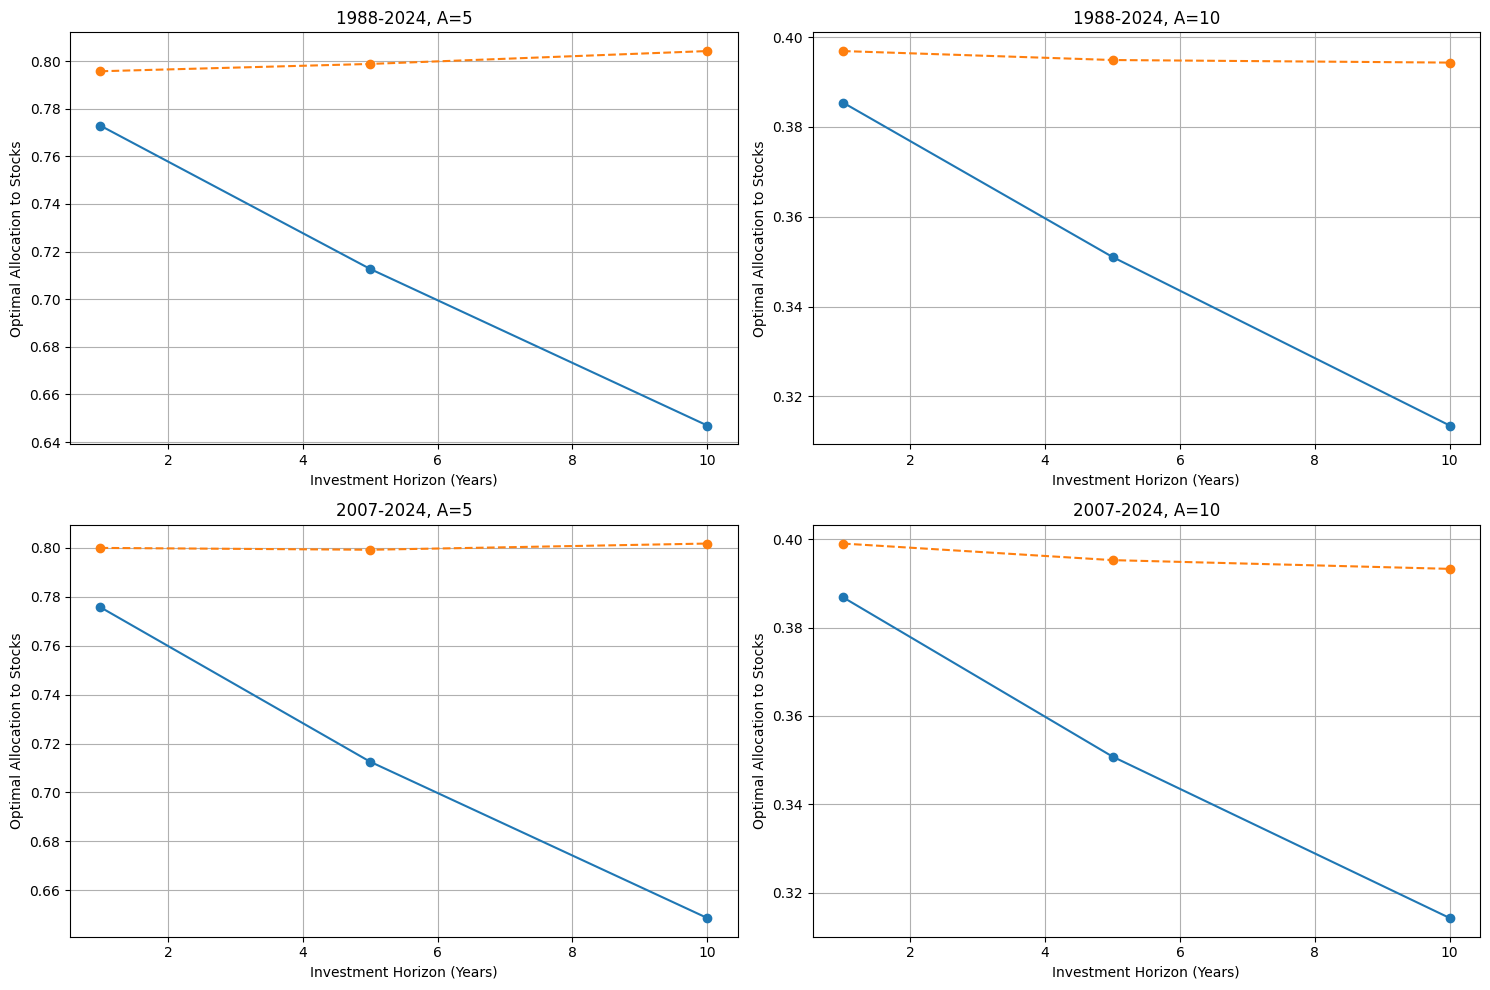

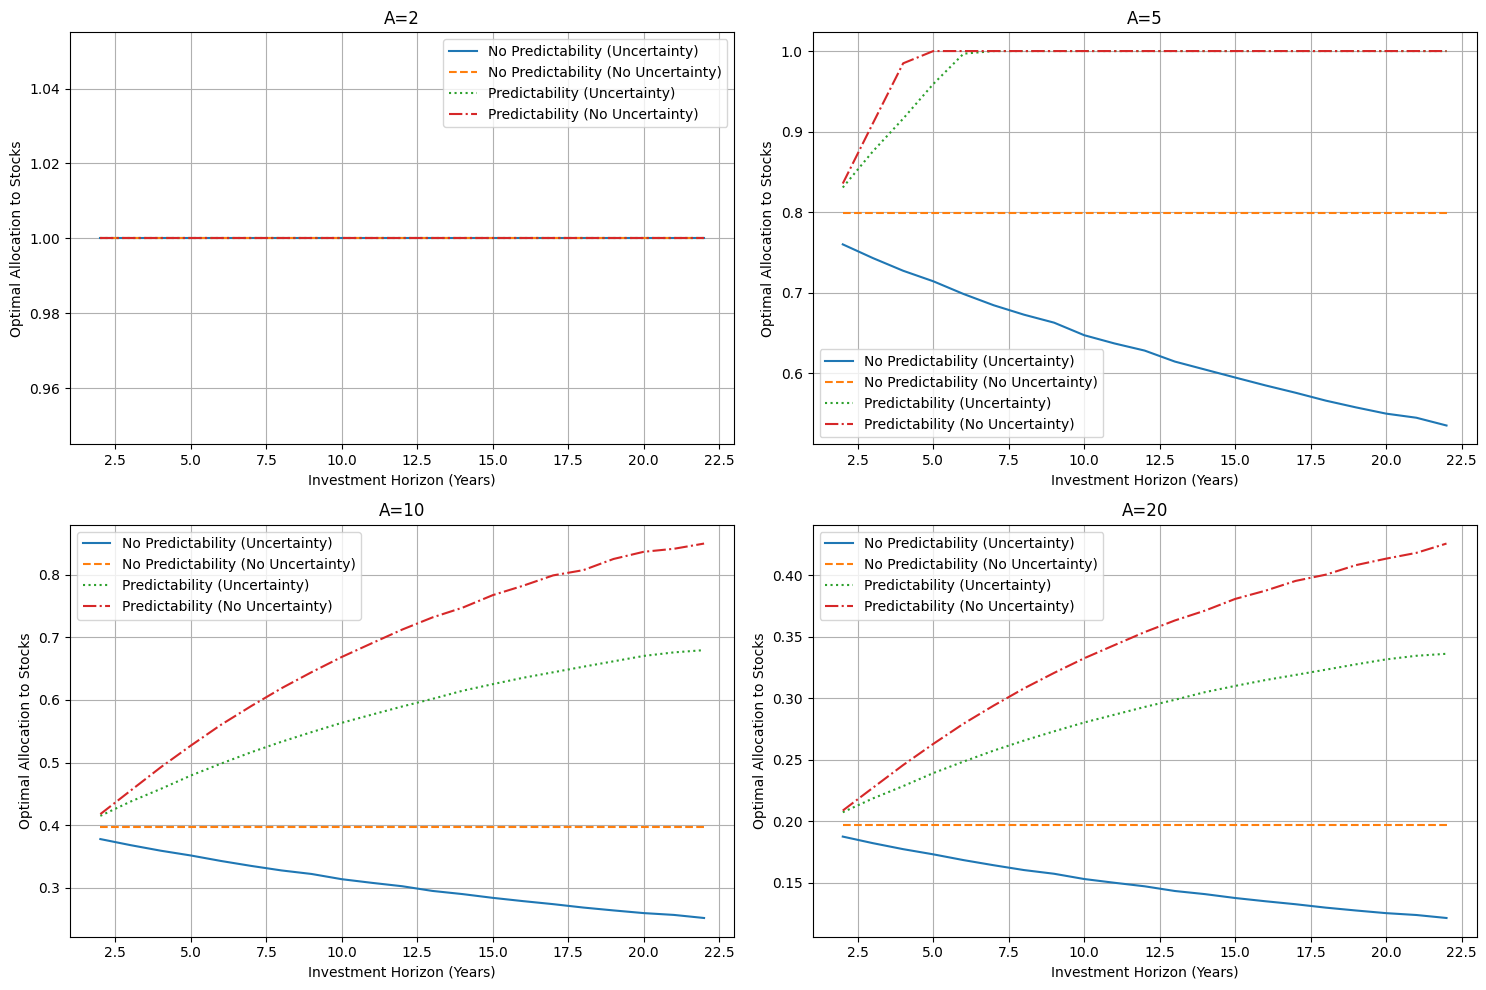

In [16]:
# Run posterior simulations for optimal stock allocation
Posterior(returns_stocks, returns_bond, T, figure = 1)
#o1-(no predic,si uncert) o2-(no predic, no uncert) o3-(predic,si uncert) o4-(predict, no uncert)
o1,o2,o3,o4=Posterior(returns_stocks,returns_bond,T,figure=2)

## DIVIDEND YIELD

In [9]:
def Posterior2(returns_stocks, returns_bond, T):
    
    Aversion = [5, 10, 20]

    rang = rang = list(range(2, 21))
    n_samples = 10000
    r_f = np.mean(returns_bond)

    #div_values = [[0,-0.00169],[0,-0.000884],[0,np.mean(First_Diff_Yield)],[0,0.00084],[0,0.00168]]
    div_values = [[0,-0.0085353],[0,-0.00504353],[0,0],[0,0.00505354],[0,0.00854436]] #Modify the produce better plot
    #div_values = [[0,-0.169],[0,-0.0884],[0,np.mean(First_Diff_Yield)],[0,0.084],[0,0.168]] #Modify the produce better plot
    
    forecast = []
    #Talk only about forecast with new dividend yield, substitute the last dividend yield of series
    for d in div_values:
        d[0] = Stocks_Model.iloc[-1].values[0]
        resu_unc = res.forecast(np.array([d]), 20)  # For uncertainty
        resu_no_unc = res2.forecast(np.array([d]), 20)  # Without uncertainty
        forecast.append((resu_unc, resu_no_unc))

    somma_unc, somma_no_unc = zip(*forecast)

    z_T_f = div_values  # Current state

    results_predictability_uncertainty = []
    results_predictability_no_uncertainty = []
    for i in range(len(div_values)):
        results_predictability_uncertainty.append({A: [] for A in Aversion})
        results_predictability_no_uncertainty.append({A: [] for A in Aversion})

    cumulative_returns_with_uncertainty = np.zeros((len(div_values), n_samples))
    cumulative_returns_no_uncertainty = np.zeros((len(div_values), n_samples))

    # Main loop for predictions
    for T_prime in rang:
        for i, z_T in zip(range(len(div_values)), z_T_f):
            
            if T_prime - 1 != 0:
                somma_unc[i][T_prime - 1] += forecast[i][0][T_prime - 2]
            mu_sum, Sigma_sum = compute_mean_and_variance_recursive(
                somma_unc[i][T_prime - 1],
                np.squeeze(np.asarray(test[0])),
                test[1:, :],
                res.resid_acov()[0],
                T_prime
            )
            simulated_returns = multivariate_normal.rvs(mean=mu_sum, cov=Sigma_sum, size=n_samples)
            cumulative_returns_with_uncertainty[i] += simulated_returns[:, 0]

            mean_pred, cov_pred = compute_mean_and_variance_recursive(
                z_T,
                np.squeeze(np.asarray(test_1[0])),
                test_1[1:, :],
                res2.resid_acov()[0],
                T_prime
            )
            mean_predictive_returns = multivariate_normal.rvs(mean=mean_pred, cov=cov_pred, size=n_samples)
            cumulative_returns_no_uncertainty[i] += mean_predictive_returns[:, 0]

        for A in Aversion:
            for i, cumulative_returns in zip(range(len(cumulative_returns_with_uncertainty)), cumulative_returns_with_uncertainty):
                result_predictability_uncertainty = minimize(
                    negative_utility,
                    x0=1,
                    args=(cumulative_returns, r_f, T_prime, A),
                    bounds=[(0, 1)],
                    method="L-BFGS-B"
                )
                results_predictability_uncertainty[i][A].append(result_predictability_uncertainty.x[0])

            for i, cumulative_returns_no in zip(range(len(cumulative_returns_no_uncertainty)), cumulative_returns_no_uncertainty):
                result_predictability_no_uncertainty = minimize(
                    negative_utility,
                    x0=1,
                    args=(cumulative_returns_no, r_f, T_prime, A),
                    bounds=[(0, 1)],
                    method="L-BFGS-B"
                )
                results_predictability_no_uncertainty[i][A].append(result_predictability_no_uncertainty.x[0])

    plot_titles = ["A=5", "A=10", "A=20"]
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    color=["red","purple","black","blue","green"]
    
    # Uncertainty plots (left column)
    for idx, A in enumerate(Aversion):
        ax = axes[idx, 0]
        for div,info in enumerate(results_predictability_uncertainty):
            ax.plot(rang, info[A], label=f"Predictability (Uncertainty)-{div_values[div][1]}", linestyle=":",color=color[div])
        ax.set_title(plot_titles[idx])
        ax.set_xlabel("Investment Horizon (Years)")
        ax.set_ylabel("Optimal Allocation to Stocks")
        ax.set_ylim(0, 1)  # Set y-axis limits
        ax.grid()
    
    # No Uncertainty plots (right column)
   
    #plt.figure(figsize=(10, 5))
    for idx, A in enumerate(Aversion):
        ax = axes[idx, 1]
        for div,info in enumerate(results_predictability_no_uncertainty):
            ax.plot(rang, info[A], label=f"Predictability (No Uncertainty): {div_values[div][1]}", linestyle="-.",color=color[div])
        ax.set_title(plot_titles[idx])
        ax.set_xlabel("Investment Horizon (Years)")
        ax.set_ylabel("Optimal Allocation to Stocks")
        ax.set_ylim(0, 1)  # Set y-axis limits
        ax.grid()

    plt.legend()
    plt.tight_layout()
    plt.show()

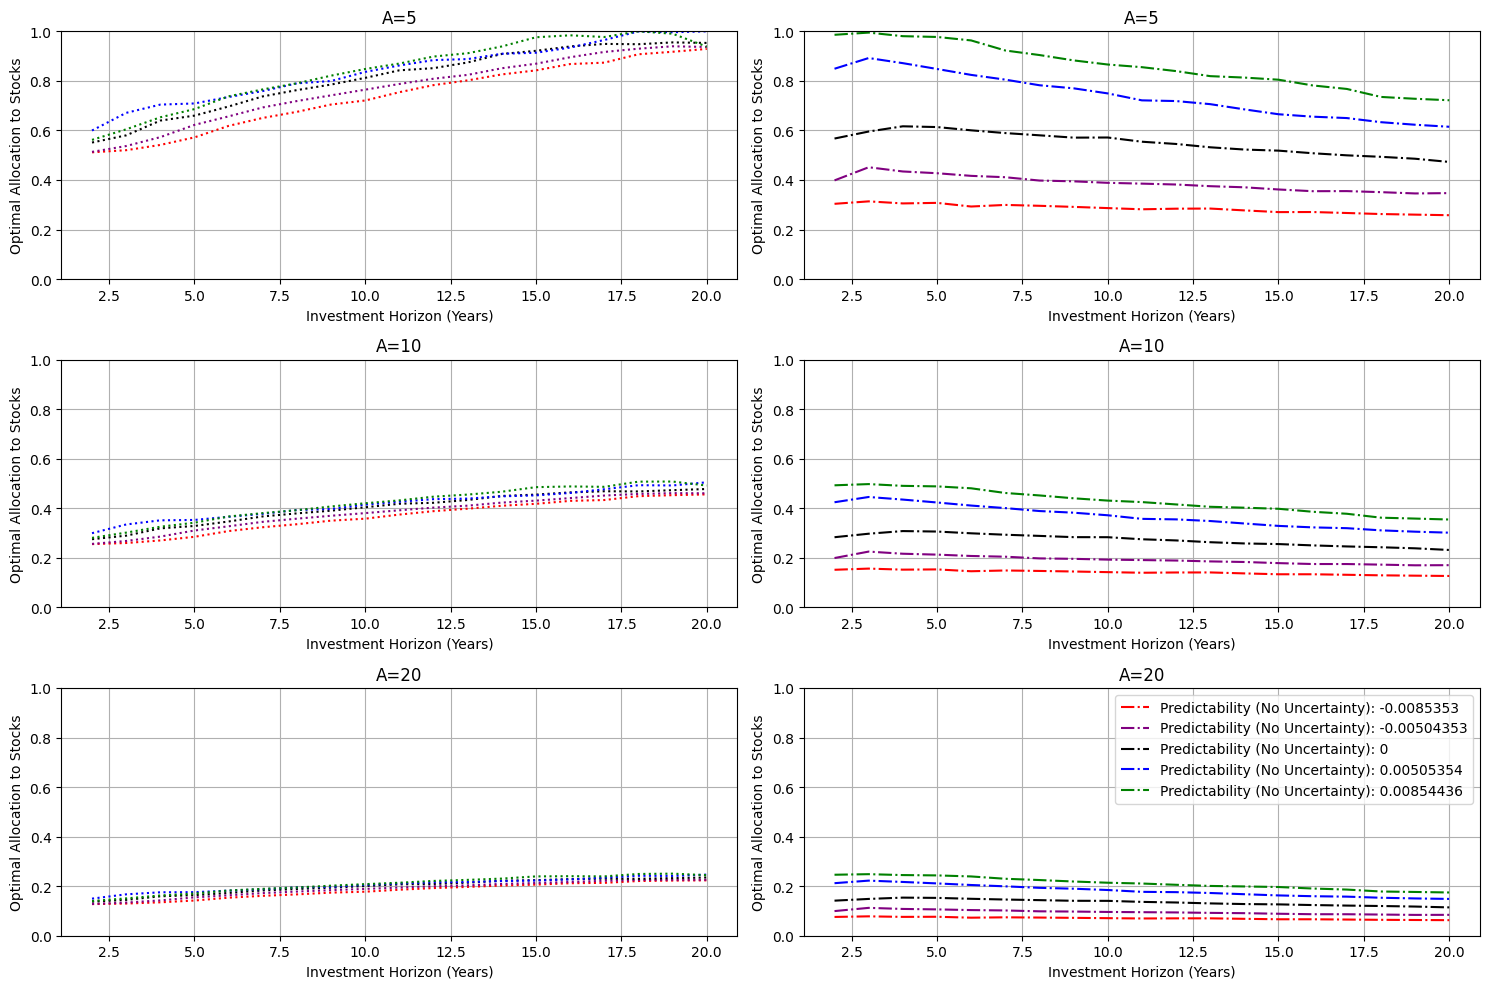

In [10]:
Posterior2(returns_stocks, returns_bond, T)

## BELLMAN Q

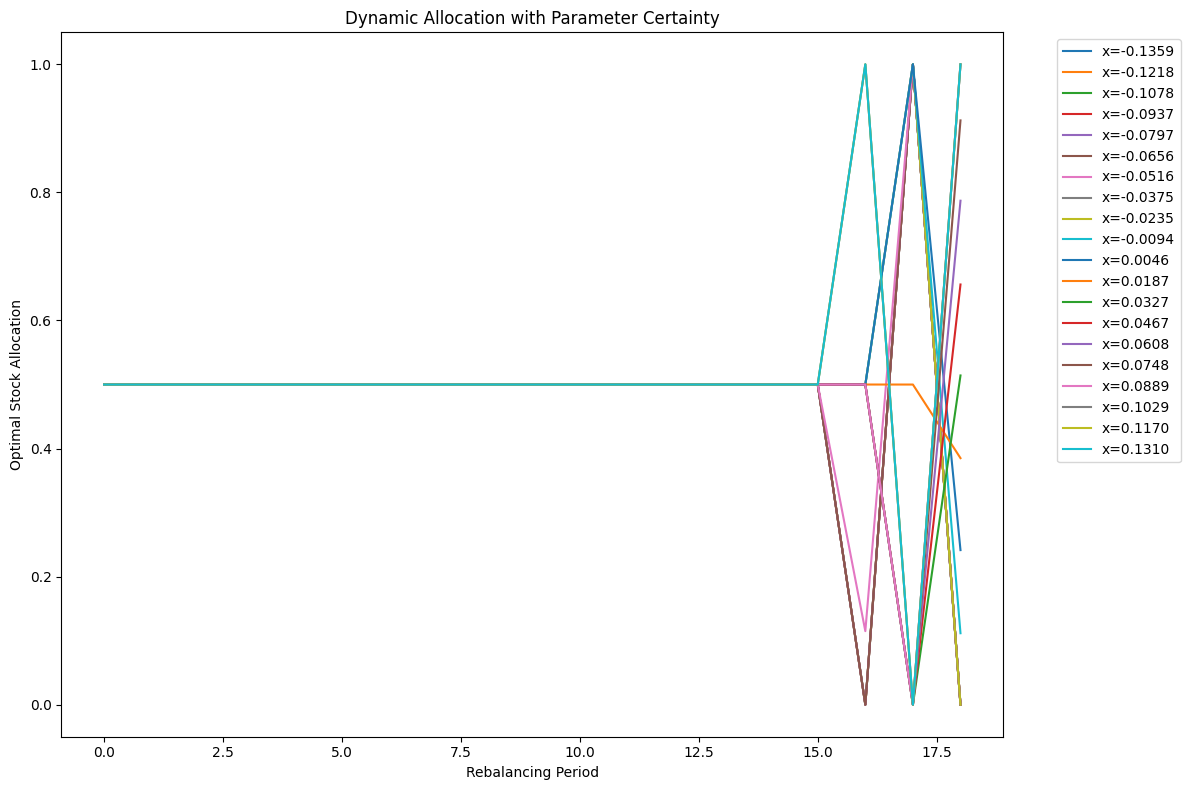

In [11]:
def dynamic_allocation(res, Stocks_Model, T_hat=20, K=20, I=100000, A=20, r_f=0.0036):
    # Discretize state space (dividend yield)
    x = Stocks_Model.iloc[:, 1].values
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_grid = np.linspace(x_mean - 3*x_std, x_mean + 3*x_std, 20)
    
    # VAR parameters
    a = res.params.iloc[0].values
    B = res.params.iloc[1:].values
    Sigma = res.sigma_u  # Correct residual covariance
    
    # Initialize Q values and allocations
    Q = np.ones((len(x_grid), K))
    optimal_omegas = np.zeros((len(x_grid), K-1))
    
    # Backward induction for k in range(0, K-2):
    for k in range(K-2, -1, -1):
        for j, x_j in enumerate(x_grid):
            z_t = np.array([0.0, x_j])
            # Use res.sigma_u instead of res.resid_acov()[0]
            mu_sum, Sigma_sum = compute_mean_and_variance_recursive(z_t, a, B, Sigma, T_hat//K)
            
            # Sample returns and x_next
            samples = multivariate_normal.rvs(mean=mu_sum, cov=Sigma_sum, size=I)
            R_samples = samples[:, 0]  # Cumulative returns
            x_next_samples = samples[:, 1]  # Next period's dividend yield
            
            # Find nearest grid points for x_next
            nearest_indices = np.argmin(np.abs(x_next_samples[:, None] - x_grid), axis=1)
            
            # Compute expected Q_next
            Q_next = Q[nearest_indices, k+1]
            
            # Define expected utility function for optimization
            def expected_utility(omega):
                portfolio_returns = (1 - omega)*np.exp(r_f*(T_hat/K)) + omega*np.exp(r_f*(T_hat/K) + R_samples)
                utilities = (portfolio_returns**(1 - A))/(1 - A) * Q_next
                return -np.mean(utilities)
            
            # Optimize omega
            result = minimize(expected_utility, x0=0.5, bounds=[(0, 1)], method='L-BFGS-B')
            optimal_omegas[j, k] = result.x[0]
            Q[j, k] = -result.fun
    
    return x_grid, optimal_omegas, Q

# Assuming res is the fitted VAR model from previous code
x_grid, optimal_omegas, Q = dynamic_allocation(res, Stocks_Model)

# Visualization
plt.figure(figsize=(12, 8))
for j in range(len(x_grid)):
    plt.plot(optimal_omegas[j], label=f'x={x_grid[j]:.4f}')
plt.xlabel('Rebalancing Period')
plt.ylabel('Optimal Stock Allocation')
plt.title('Dynamic Allocation with Parameter Certainty')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## PENSION FUND

In [18]:

clear_returns_stocks = np.exp(returns_stocks) - 1
clear_returns_bond = np.exp(returns_bond) - 1

In [34]:

def pension_pac_simulatior(ret_stocks,ret_bonds,Initial_Capital=10000,PAC=1,YtP=10,omega1=0,omega2=0,omega3=0,omega4=0,A=5):
    omegas=[omega1,omega2,omega3,omega4]
    anni = np.arange(YtP)
    disegno = ["No_predic_With_uncert","No_predic_no_uncert","Predic_uncert","Predic_no_uncert"]
    dati = pd.DataFrame({"Anno": anni/12+(2024-YtP/12)})
    for i,omega in enumerate(omegas):
        nuovo_capitale = np.zeros(YtP)
        capitale = [Initial_Capital]
        
        for t in range(YtP-1):
            # Calcola il rendimento combinato dell'anno t
            rendimento_totale = omega* ret_stocks.iloc[(len(ret_stocks)-YtP)+t] + (1 - omega) * ret_bonds.iloc[(len(ret_stocks)-YtP)+t]
            # Aggiorna il capitale
            nuovo_capitale[t] = (capitale[-1] * (1 + rendimento_totale))
            capitale.append(nuovo_capitale[t])

        # Creazione DataFrame per visualizzazione
        dati["Capitale"+str(i)] = capitale

    nuovo_capitale_spx = np.zeros(YtP)
    capitale_spx = [Initial_Capital]
    for t in range(YtP-1):
        # Aggiorna il capitale investendo al 100% nello SPX500
        nuovo_capitale_spx[t] = capitale_spx[-1] * (1 +  ret_stocks.iloc[(len(ret_stocks)-YtP)+t])
        capitale_spx.append(nuovo_capitale_spx[t])
    dati["Capitale_SPX"] = capitale_spx
    # Visualizzazione del grafico
    plt.figure(figsize=(10, 6))
    for col,omega,dis in zip(dati.columns[1:-1],omegas,disegno):
        plt.plot(dati["Anno"], dati[col], linestyle="-", label=f'A={A},{dis},omega = {omega:.3f}')
    plt.plot(dati["Anno"], dati["Capitale_SPX"], linestyle='--', label='S%P 500 portfolio')
    plt.title("Pension fund development", fontsize=14)
    plt.xlabel("Year", fontsize=12) 
    plt.ylabel("Capital (€)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()

    plt.close()


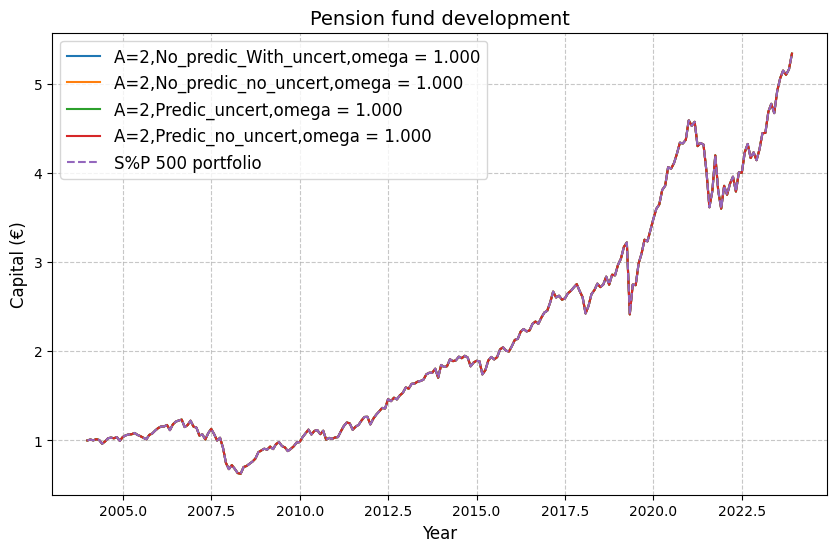

In [14]:

T_e= 20
A =2
pension_pac_simulatior(clear_returns_stocks,clear_returns_bond,1,1,12*20,o1[A][T_e],o2[A][T_e],o3[A][T_e],o4[A][T_e],A)

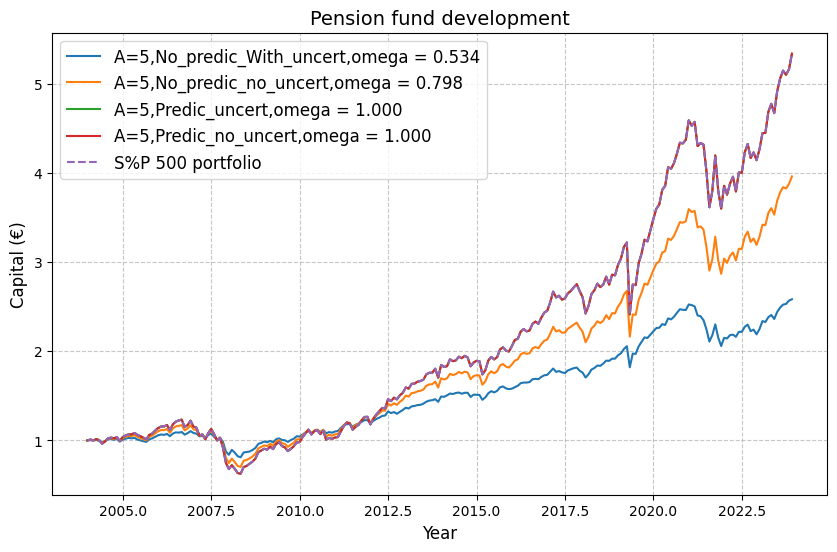

In [15]:

T_e= 20
A =5
pension_pac_simulatior(clear_returns_stocks,clear_returns_bond,1,1,12*20,o1[A][T_e],o2[A][T_e],o3[A][T_e],o4[A][T_e],A)

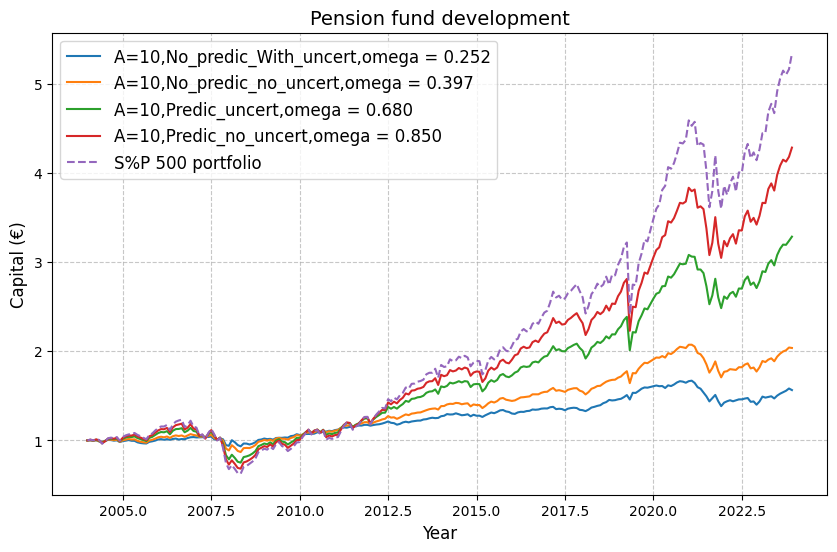

In [33]:

T_e= 20
A =10
pension_pac_simulatior(clear_returns_stocks,clear_returns_bond,1,1,12*20,o1[A][T_e],o2[A][T_e],o3[A][T_e],o4[A][T_e],A)

In [28]:


def pension_pac_simulatior_dynamic(ret_stocks,ret_bonds,Initial_Capital=1,PAC=1,YtP=10,omega1=0,omega2=0,omega3=0,omega4=0,A=5):
    omegas=[omega1,omega2,omega3,omega4]
    anni = np.arange(YtP)
    disegno = ["No_predic_With_uncert","No_predic_no_uncert","Predic_uncert","Predic_no_uncert"]
    dati = pd.DataFrame({"Anno": anni/12+(2024-YtP/12)})
    for i,omega in enumerate(omegas):
        nuovo_capitale = np.zeros(YtP)
        capitale = [Initial_Capital]
        
        for t in range(YtP-1):
      
            # Calcola il rendimento combinato dell'anno t
            rendimento_totale = omega[int(t // 12) ]* ret_stocks.iloc[(len(ret_stocks)-YtP)+t] + (1 - omega[t // 12]) * ret_bonds.iloc[(len(ret_stocks)-YtP)+t]
            # Aggiorna il capitale
            nuovo_capitale[t] = (capitale[-1] * (1 + rendimento_totale))+PAC
            capitale.append(nuovo_capitale[t])

        # Creazione DataFrame per visualizzazione
        dati["Capitale"+str(i)] = capitale

    nuovo_capitale_spx = np.zeros(YtP)
    capitale_spx = [Initial_Capital]
    for t in range(YtP-1):
        # Aggiorna il capitale investendo al 100% nello SPX500
        nuovo_capitale_spx[t] = capitale_spx[-1] * (1 +  ret_stocks.iloc[(len(ret_stocks)-YtP)+t])+1
        capitale_spx.append(nuovo_capitale_spx[t])
    dati["Capitale_SPX"] = capitale_spx
    # Visualizzazione del grafico
    plt.figure(figsize=(10, 6))
    for col,omega,dis in zip(dati.columns[1:-1],omegas,disegno):
            plt.plot(dati["Anno"], dati[col], linestyle="-", label=f'A={A},{dis}')
    plt.plot(dati["Anno"], dati["Capitale_SPX"], linestyle='--', label='S%P 500 portfolio')
    plt.title("Pension fund development", fontsize=14)
    plt.xlabel("Year", fontsize=12) 
    plt.ylabel("Capital (€)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()





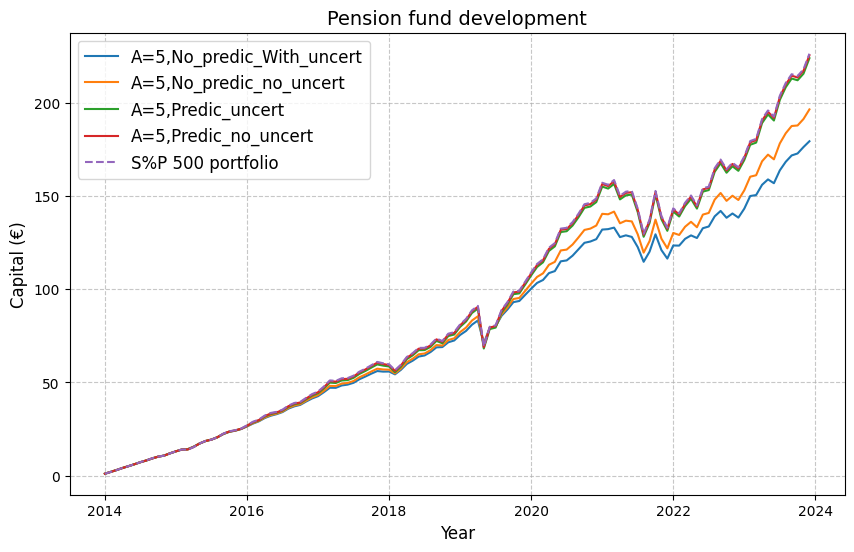

In [29]:


T_e= 10
A =5
pension_pac_simulatior_dynamic(clear_returns_stocks,clear_returns_bond,1,1,12*10,o1[A],o2[A],o3[A],o4[A],A)

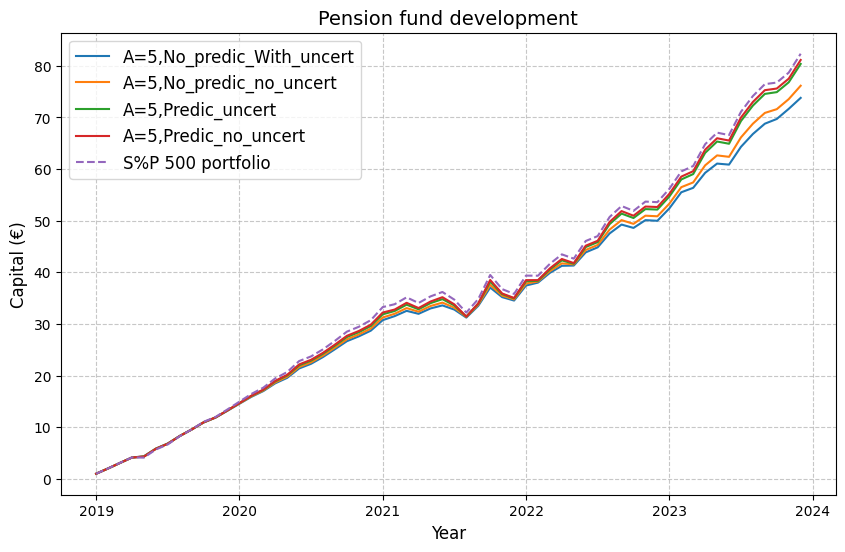

In [19]:


T_e= 5
A =5
pension_pac_simulatior_dynamic(clear_returns_stocks,clear_returns_bond,1,1,12*5,o1[A],o2[A],o3[A],o4[A],A)

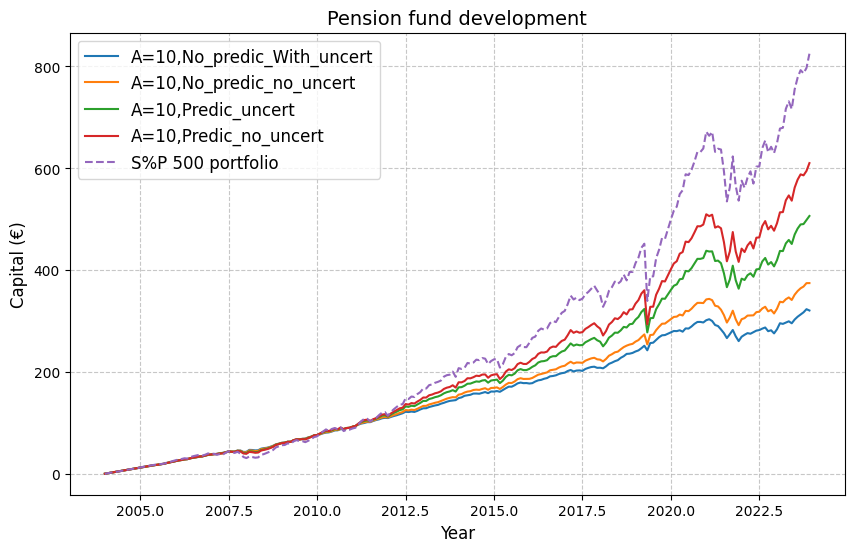

In [20]:


T_e= 10
A =10
pension_pac_simulatior_dynamic(clear_returns_stocks,clear_returns_bond,1,1,12*20,o1[A],o2[A],o3[A],o4[A],A)

In [20]:

def pension_fund_simulation_PAC(o1,o2,o3, init_W, horizon_years, month_inj, stock_excess_return, bond_return):
    s = [o1,o2,o3]
    lab=["A=5:neutral,IW="+str(init_W[0])+", PAC="+str(month_inj[0]),f"A=10:Adverse-Neutral,IW="+str(init_W[1])+",PAC="+str(month_inj[1]),f"A=20:Adverse,IW="+str(init_W[2])+",PAC="+str(month_inj[2])]
    time_periods = np.arange(0, horizon_years) / 12  # Convert to years
    results_df = pd.DataFrame({'Year': time_periods})
    conta = 0
    for omega,initial_wealth,monthly_injection in zip(s,init_W,month_inj):
        print(omega,initial_wealth,monthly_injection)
        # Compute the annualized return of the portfolio
        b = 1 - omega  # Bond percentage
        
        # Initialize wealth tracking
        months = horizon_years
        wealth = np.zeros(months)
        wealth[-1] = initial_wealth
        
        # Simulate wealth accumulation
        for month in range(months):
            # Apply monthly return (assuming returns compound monthly)
            monthly_return = omega * stock_excess_return.iloc[(len(stock_excess_return)-months)+month] + b * bond_return.iloc[(len(bond_return)-months)+month]
            wealth[month] = wealth[month - 1] *(1+monthly_return) +monthly_injection
        results_df[ 'Wealth'+str(conta)] = wealth
        conta+=1
        # Create a DataFrame for visualization
  
        # Plot the pension fund growth
    plt.figure(figsize=(10, 5))
    print(results_df.columns[1:])
    for col,l in zip(results_df.columns[1:],lab):
            plt.plot(results_df['Year'], results_df[col], label=l)
    plt.xlabel("Years")
    plt.ylabel("Wealth (€)")
    plt.title("Pension Fund Growth Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()
        
    

1.0 0 500
0.6795413094241516 5000 750
0.3362718252091629 10000 1000
Index(['Wealth0', 'Wealth1', 'Wealth2'], dtype='object')


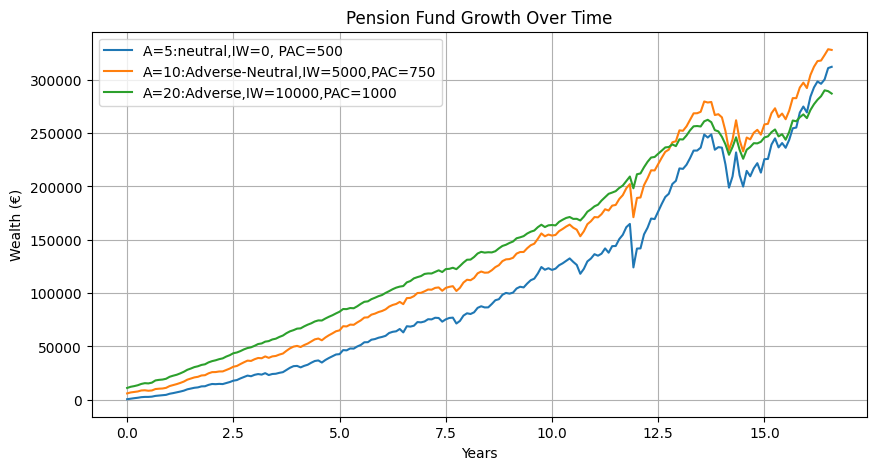

In [ ]:
pension_fund_simulation_PAC(o3[5][20],o3[10][20],o3[20][20],[0,5000,10000],10*20,[500,750,1000],clear_returns_stocks,clear_returns_bond)

## VOLATILITY CONES

In [21]:
def stationary_bootstrap_MC(data, B, w, nt):
    if len(data.shape) > 1:
        raise ValueError("DATA must be a column vector")
    if len(data) < 2:
        raise ValueError("DATA must have at least 2 observations.")
    if w <= 0:
        raise ValueError("W must be a positive scalar.")
    if B < 1 or not isinstance(B, int):
        raise ValueError("B must be a positive scalar integer.")

    t = max(len(data), nt)

    # Probability of starting a new block
    p = 1 / w

    # Initialize indices
    indices = np.zeros((t, B), dtype=int)

    # Initial positions
    indices[0, :] = np.random.randint(0, len(data), size=B)

    # Generate random numbers to decide whether to start a new block
    select = np.random.rand(t, B) < p
    indices[select] = np.random.randint(0, len(data), size=select.sum())

    for i in range(1, t):
        indices[i, ~select[i, :]] = indices[i - 1, ~select[i, :]] + 1

    # Wrap around indices exceeding the length of data
    indices = np.mod(indices, len(data))

    # Generate bootstrapped data
    bsdata = data[indices]

    return bsdata[:nt, :], indices[:nt, :]


In [22]:
def compute_moments(data):
    mean_annual = ((1 + np.mean(data, axis=0)) ** 12) - 1
    mean_10yr = ((1 + mean_annual) ** 10) - 1

    cov_annual = np.cov(data, rowvar=False) * 12
    cov_10yr = cov_annual * 10

    return mean_10yr, cov_10yr


In [23]:
def bootstrap_moments(data, M, N, w):
    T, N_assets = data.shape
    indices, _ = stationary_bootstrap_MC(np.arange(T), M, w, N)

    mean_bootstrap = np.zeros(N_assets)
    cov_bootstrap = np.zeros((N_assets, N_assets))
    returns_all = []

    for i in range(M):
        sampled_data = data[indices[:, i], :]
        cum_returns = np.prod(1 + sampled_data, axis=0) - 1
        returns_all.append(cum_returns)

        mean_bootstrap += cum_returns
        cov_bootstrap += np.cov(sampled_data, rowvar=False) * 12 * 10

    mean_bootstrap /= M
    cov_bootstrap /= M

    returns_all = np.array(returns_all)
    cov_from_returns = np.cov(returns_all, rowvar=False) / 10

    return mean_bootstrap, cov_bootstrap, cov_from_returns

In [24]:
def simulate_var_paths(var_model, initial_state, n_periods, n_simulations):
    """
    Simulate paths using a fitted VAR model with statsmodels.
    """
    n_vars = var_model.neqs
    p = var_model.k_ar  # Lag order
    paths = np.zeros((n_periods, n_simulations, n_vars))
    
    # Get residuals and their covariance
    residuals = var_model.resid  # Residuals (T x m matrix)
    residual_cov = var_model.sigma_u  # Residual covariance matrix
    
    for i in range(n_simulations):
        # Initialize with the last `p` observations (ensure alignment)
        current_state = initial_state.copy()
        
        for t in range(n_periods):
            # Forecast next step using VAR coefficients
            forecast = var_model.forecast(current_state, steps=1)
            # Add correlated shock (sampled from residuals)
            shock = multivariate_normal.rvs(mean=np.zeros(n_vars), cov=residual_cov)
            paths[t, i] = forecast + shock
            # Update state (append new observation, drop oldest)
            current_state = np.vstack([current_state[1:], paths[t, i]])
    
    return paths

In [25]:
def simulate_bayesian_var_paths(sampled_C, sampled_Sigma, initial_state, n_periods, n_simulations):
    """
    Simulate paths using Bayesian VAR posterior samples.
    """
    n_vars = initial_state.shape[1]
    paths = np.zeros((n_periods, n_simulations, n_vars))
    
    for i in range(n_simulations):
        # Sample VAR parameters from posterior
        C = sampled_C[i]
        Sigma = sampled_Sigma[i]
        current_state = initial_state.copy()
        
        for t in range(n_periods):
            # Compute forecast: Z_{t+1} = C0 + C1 * Z_t + ...
            forecast = C[0] + current_state @ C[1:]
            # Add shock
            shock = multivariate_normal.rvs(mean=np.zeros(n_vars), cov=Sigma)
            paths[t, i] = forecast + shock
            # Update state
            current_state = np.roll(current_state, -1)
            current_state[-1] = paths[t, i]
    
    return paths

In [33]:
def plot_volatility_cone(data, weights, M, N, w, scenario="bootstrap", var_model=None, initial_state=None):
    T, N_assets = data.shape
    portfolio_paths = np.zeros((N, M))
    
    if scenario == "bootstrap":
        # Existing stationary bootstrap
        indices, _ = stationary_bootstrap_MC(np.arange(T), M, w, N)
        for i in range(M):
            sampled_data = data[indices[:, i], :]
            portfolio_paths[:, i] = np.cumprod(1 + sampled_data @ weights)
    
    elif scenario == "var":
        # VAR-based simulation
        if var_model is None or initial_state is None:
            raise ValueError("VAR model and initial state required.")
        # Simulate paths
        var_paths = simulate_var_paths(var_model, initial_state, N, M)
        # Extract asset returns (assuming first column is returns)
        asset_returns = var_paths[:, :, 0]
        for i in range(M):
            portfolio_paths[:, i] = np.cumprod(1 + asset_returns[:, i] * weights[0])
        """
    elif scenario == "bayesian_var":
        # Bayesian VAR simulation
        if var_model is None or initial_state is None:
            raise ValueError("Bayesian VAR samples and initial state required.")
        # Sample from posterior (using your existing `bayesian_var_sampler_VAR`)
        sampled_C, sampled_Sigma = bayesian_var_sampler_VAR(data, p=1, n_samples=M)
        # Simulate paths
        bayesian_paths = simulate_bayesian_var_paths(sampled_C, sampled_Sigma, initial_state, N, M)
        # Extract asset returns
        asset_returns = bayesian_paths[:, :, 0]
        for i in range(M):
            portfolio_paths[:, i] = np.cumprod(1 + asset_returns[:, i] * weights[0])
        """
    else:
        raise ValueError("Invalid scenario. Choose 'bootstrap', 'var', or 'bayesian_var'.")
    
    # Calculate quantiles and plot (same as before)
    quantiles = np.percentile(portfolio_paths, [5, 50, 95], axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(quantiles[1], '-k', label="Median", linewidth=2)
    plt.fill_between(range(N), quantiles[0], quantiles[2], color='gray', alpha=0.3, label="90% CI")
    plt.title(f"Volatility Cone ({scenario.capitalize()} Scenario)")
    plt.xlabel("Months")
    plt.ylabel("Portfolio Value")
    plt.ylim(0,3.5)
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
# Define initial state (last `p` observations)
initial_state = Stocks_Model.iloc[-res.k_ar:].values  # For VAR(1), k_ar=1

In [28]:
# Sample from Bayesian VAR posterior
campioni_C, campioni_Sigma = bayesian_var_sampler_VAR(Stocks_Model, p=1, n_samples=1000)

In [30]:
# Combine returns for stocks and bonds
combined_returns = pd.concat([returns_stocks, returns_bond], axis=1).dropna()
combined_returns.columns = ["Stocks", "Bonds"]

# Compute moments
mean_10yr, cov_10yr = compute_moments(combined_returns.to_numpy())



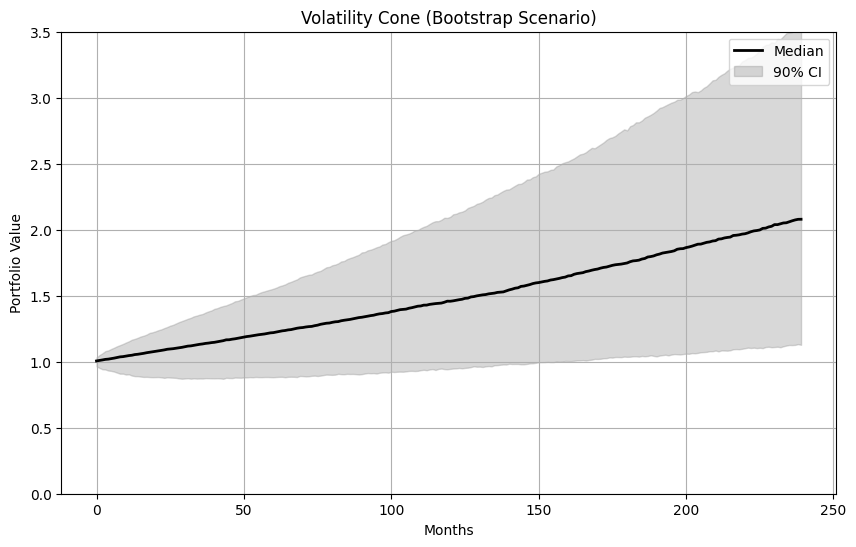

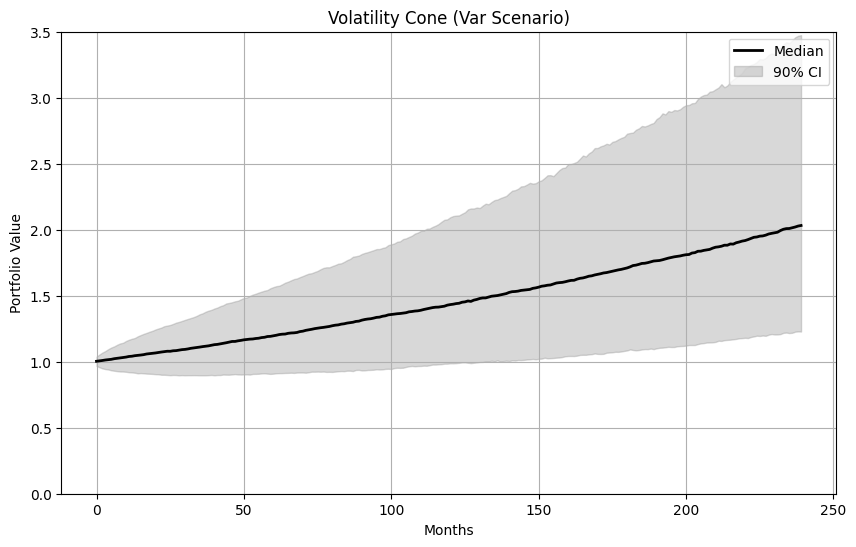

In [34]:
# Scenario 1: Bootstrap (No Predictability)
plot_volatility_cone(combined_returns.to_numpy(), weights=np.array([0.5, 0.5]), 
                     M=5000, N=240, w=6, scenario="bootstrap")

# Scenario 2: VAR with Predictability
plot_volatility_cone(Stocks_Model.to_numpy(), weights=np.array([0.5, 0.5]), 
                     M=5000, N=240, w=6, scenario="var", 
                     var_model=res, initial_state=initial_state)

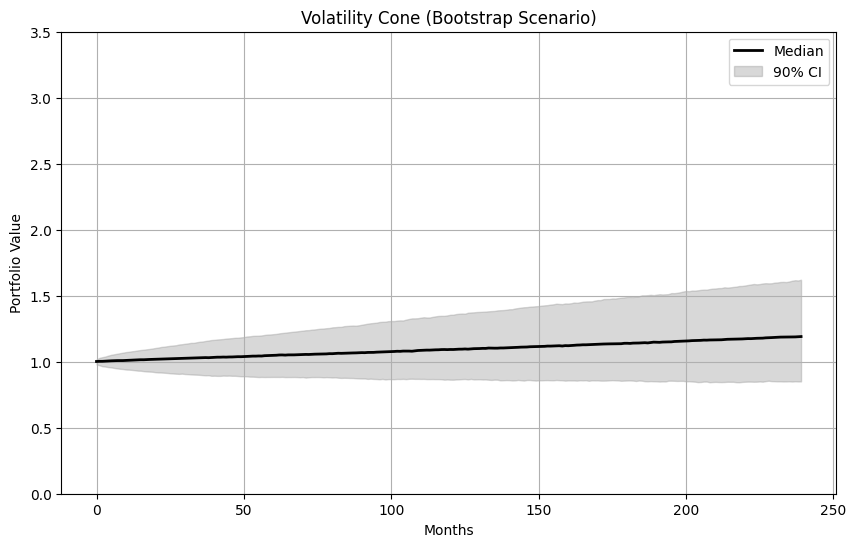

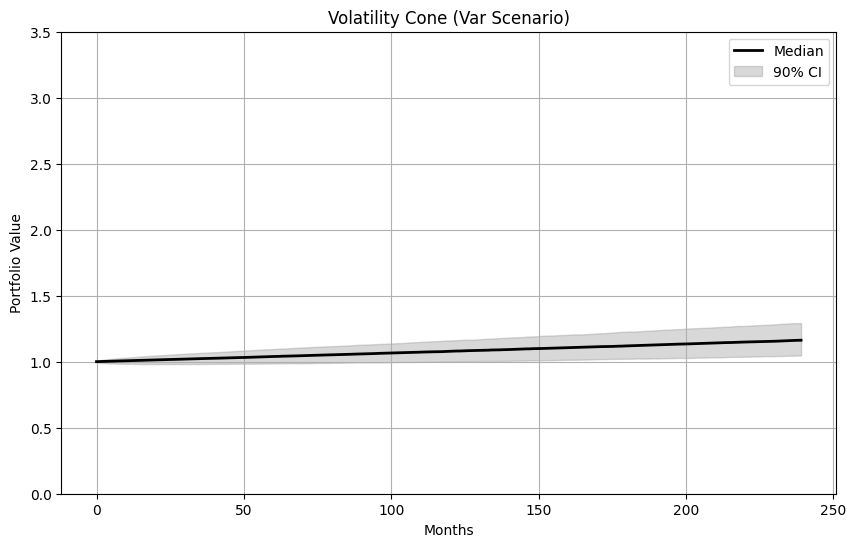

In [35]:
# Scenario 1: Bootstrap (No Predictability)
plot_volatility_cone(combined_returns.to_numpy(), weights=np.array([0.1, 0.9]), 
                     M=5000, N=240, w=6, scenario="bootstrap")

# Scenario 2: VAR with Predictability
plot_volatility_cone(Stocks_Model.to_numpy(), weights=np.array([0.1, 0.9]), 
                     M=5000, N=240, w=6, scenario="var", 
                     var_model=res, initial_state=initial_state)

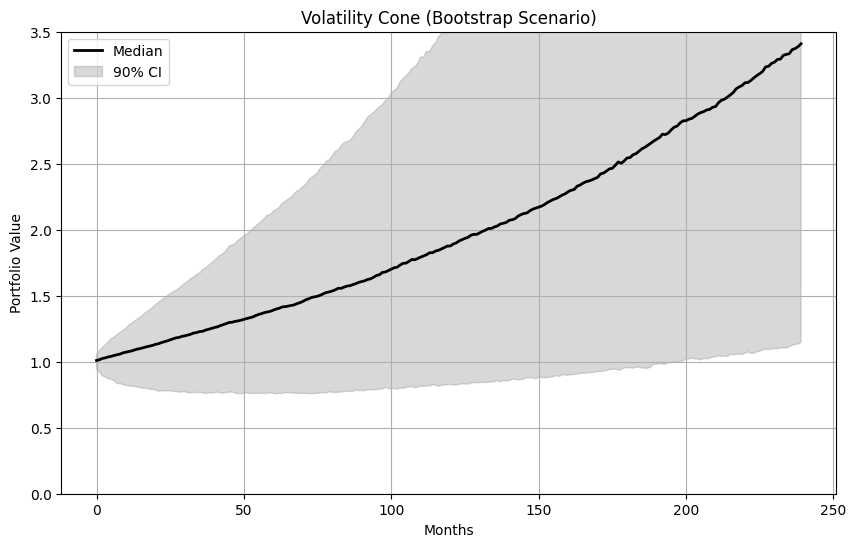

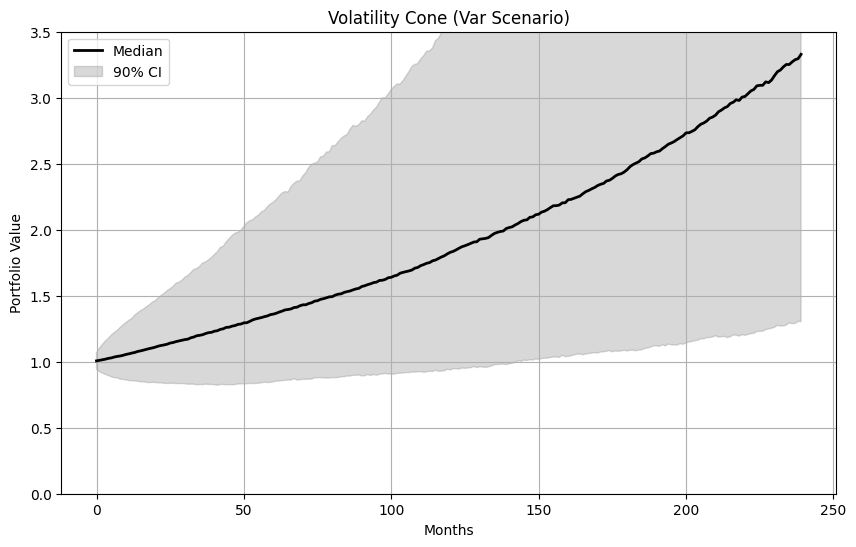

In [36]:
# Scenario 1: Bootstrap (No Predictability)
plot_volatility_cone(combined_returns.to_numpy(), weights=np.array([0.9, 0.1]), 
                     M=5000, N=240, w=6, scenario="bootstrap")

# Scenario 2: VAR with Predictability
plot_volatility_cone(Stocks_Model.to_numpy(), weights=np.array([0.9, 0.1]), 
                     M=5000, N=240, w=6, scenario="var", 
                     var_model=res, initial_state=initial_state)